## Exercise 1

尝试为MNIST数据集建立一个分类器，在测试集上达到超过97%的准确率。提示： **KNeighborsClassifier** 非常适合这个任务；你只需要找到好的超参数值（尝试对 **weights** 和 **n_neighbors** 超参数进行网格搜索）。

**答案**：

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

In [5]:
mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

0.9688

具有默认超参数的常规 KNN 分类器已经非常接近我们的目标。

让我们看看调整超参数是否有帮助。为了加快搜索速度，让我们只训练前 10,000 张图像：

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"],
               'n_neighbors': [3, 4, 5, 6]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)

grid_search.fit(X_train[:10_000], y_train[:10_000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [9]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [10]:
grid_search.best_score_

0.9441999999999998

分数下降了，但这是意料之中的，因为我们只训练了 10,000 张图像。 所以让我们选择最好的模型并在完整的训练集上再次训练它：

In [11]:
grid_search.best_estimator_.fit(X_train, y_train)

tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

我们达到了 97% 准确率的目标！

## Exercise 2

编写一个函数，可以将MNIST图像向任何方向（左、右、上、下）移动一个像素。然后，对于训练集中的每幅图像，创建四个移动的副本（每个方向一个），并将它们添加到训练集中。最后，在这个扩展的训练集上训练你的最佳模型，并在测试集上测量它的准确性。你应该注意到，你的模型现在表现得更好了！这种人工增长训练集的技术被称为数据增强或训练集扩展。

In [12]:
from scipy.ndimage import shift

In [13]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

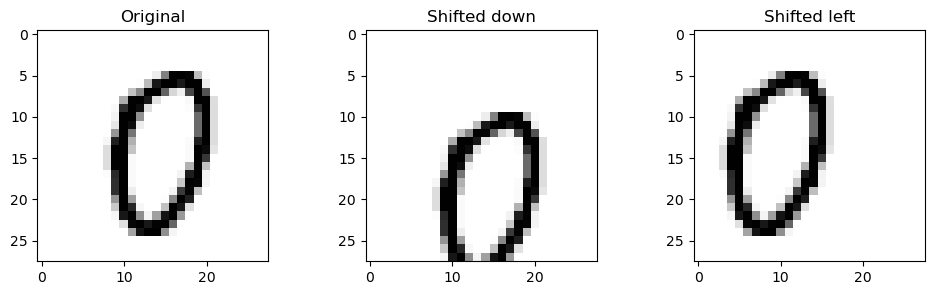

In [16]:
image = X_train[1000]  # some random digit to demo

shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")

plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")

plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [19]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

让我们洗牌增强训练集，否则所有移动的图像将被组合在一起：

In [21]:
shuffle_idx = np.random.permutation(len(X_train_augmented))

X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

现在让我们使用在上一个练习中找到的最佳超参数来训练模型：

In [23]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [24]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [25]:
augmented_accuracy = knn_clf.score(X_test, y_test)

augmented_accuracy

0.9763

通过简单地扩充数据，我们的准确度提高了 0.5%。 也许听起来没有那么令人印象深刻，但实际上意味着错误率大幅下降：

In [26]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1

print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -17%


由于数据增强，错误率下降了很多。

## Exercise 3

处理泰坦尼克号数据集。或者，您可以从 https://homl.info/titanic.tgz 下载数据并解压缩这个数据库，就像您在第2章中所做的住房数据一样。这将提供两个CSV文件，train.csv 和 test.csv，您可以使用 **pandas.read_csv()** 加载。目标是训练一个分类器，可以基于其他列预测 Survived 列。

**答案**：

In [5]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as titanic_tarball:
        titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [6]:
train_data, test_data = load_titanic_data()

In [7]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train_data = train_data.set_index("PassengerId")

test_data = test_data.set_index("PassengerId")

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [10]:
train_data[train_data["Sex"]=="female"]["Age"].median()

27.0

In [11]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [13]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [14]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [15]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [18]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [19]:
cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),    
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [20]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [21]:
X_train = preprocess_pipeline.fit_transform(train_data)

X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [22]:
y_train = train_data["Survived"]

In [25]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
X_test = preprocess_pipeline.transform(test_data)

y_pred = forest_clf.predict(X_test)

In [29]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)

forest_scores.mean()

0.8137578027465668

In [30]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

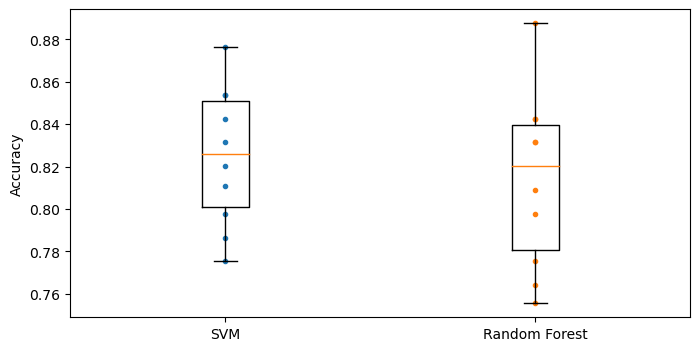

In [31]:
plt.figure(figsize=(8, 4))

plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")

plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))

plt.ylabel("Accuracy")
plt.show()

In [32]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15

train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [34]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]

train_data[["RelativesOnboard", "Survived"]].groupby(
    ['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## Exercise 4

构建一个垃圾邮件分类器（一个更具挑战性的练习）：

1. 从 Apache SpamAssassin’s public datasets 下载垃圾邮件和邮件的例子。
2. 解压缩数据集，并熟悉该数据格式。
3. 将数据分割成一个训练集和一个测试集。
4. 编写一个数据准备管道，将每个电子邮件转换为一个特征向量。你的准备管道应该将电子邮件转换为一个（稀疏的）向量，它表示每个可能的单词的存在或不存在。例如，如果所有的电子邮件只包含四个词，“Hello”, “how”, “are”, “you”,那么电子邮件“Hello you Hello Hello you”将转换为一个向量 \[1,0,0,1\] ，或 \[3,0,0,2\] 如果你喜欢计算每个单词的出现的数量。您可能想要添加超参数到您的准备管道，以控制是否剥离电子邮件标题，将每个电子邮件转换为小写，删除标点符号，用“URL”替换所有URL，将所有数字替换为“NUMBER”，甚至执行 stemming（例如，修剪词的结尾；有Python库可以做到这一点）。
5. 最后，尝试几个分类器，看看你是否可以建立一个不错的的垃圾邮件分类器，同时具有高查全率和高精度。

**答案**：

In [35]:
import tarfile

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [36]:
ham_dir, spam_dir = fetch_spam_data()

In [37]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [38]:
len(ham_filenames)

2500

In [39]:
len(spam_filenames)

500

In [40]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [41]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

In [42]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/
